### Importing Pandas, Numpy, Matplotlib and our ANN Classes

In [77]:
import pandas as pd
import numpy as np
from model import Model
from layer import Linear, ActivationFunc
from loss import Loss
from network import SequentialNetwork
from optimizer import Optimizer, adamOptimizer
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator
import matplotlib.patches as mpatches
from model import Model
from sklearn.metrics import confusion_matrix

<br>

### Loading Testing Data

In [96]:
testingData = np.load('trainingData.npy')
testingData = testingData.T
print('First 5 rows of testing data: ')
print('\n')
print(testingData[:5,:])

testing_intputs = testingData[:,0:2]
testing_truth = testingData[:,2]


#obtaining 150 red giants for training because our orginial set did not include any red giants

numGiants = 0
i = 0
trainingGiants = np.empty((250,3))
while numGiants < 250:
    if testingData[i,2] == 3.0:
        trainingGiants[numGiants,:] = testingData[i,:]
        numGiants +=1
    i += 1

#obtainin additional data for training
numMainSq = 0
i = 0
mainSq = np.empty((200,3))
while numMainSq < 200:
    if testingData[i,2] == 2.0:
        mainSq[numMainSq,:] = testingData[i,:]
        numMainSq +=1
    i += 1

numWD = 0
i = 0
wD = np.empty((200,3))
while numWD < 200:
    if testingData[i,2] == 1.0:
        wD[numWD,:] = testingData[i,:]
        numWD +=1
    i += 1
    
numRD = 0
i = 0
rD = np.empty((200,3))
while numRD < 200:
    if testingData[i,2] == 0.0:
        rD[numRD,:] = testingData[i,:]
        numRD +=1
    i += 1


First 5 rows of testing data: 


[[1.17345376e+00 9.40670000e+03 2.00000000e+00]
 [1.23644014e+00 9.34870000e+03 2.00000000e+00]
 [2.44323031e+00 7.52070000e+03 2.00000000e+00]
 [1.69415001e+00 7.05230000e+03 2.00000000e+00]
 [1.18376330e+00 9.98280000e+03 2.00000000e+00]]


## Top Of Our Dataset 
(The CSV we first Used, but with brown dwarfs dropped)

In [79]:
df = pd.read_csv("6class.csv")
df_minus_bd = df[~((df['Star type'] == 0))]
df_minus_bd.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
10,3600,0.0029,0.5100,10.690,1,Red,M
11,3129,0.0122,0.3761,11.790,1,Red,M
12,3134,0.0004,0.1960,13.210,1,Red,M
13,3628,0.0055,0.3930,10.480,1,Red,M
14,2650,0.0006,0.1400,11.782,1,Red,M


<br>

### Preparing Our Dataset For Training 
-Dropping unused rows <br>
-Adding 40 Red Giants <br>
-Normalizing and shuffling data 

In [109]:
inputs = np.array(df_minus_bd.drop(['Star type', 'Luminosity(L/Lo)', 'Star color', 'Radius(R/Ro)', 'Spectral Class'], axis=1))
truth = np.array(df_minus_bd['Star type'])

for i in range(len(truth)):
    if truth[i] <= 3:
        truth[i] = truth[i] - 1

truth = np.concatenate((truth, trainingGiants[:,2],mainSq[:,2],wD[:,2],rD[:,2]), axis = 0)
truth.shape = (len(truth), 1)

inputs[:,[0,1]] = inputs[:,[1,0]]
inputs = np.vstack((inputs, trainingGiants[:,0:2],mainSq[:,0:2],wD[:,0:2],rD[:,0:2]))

mean = np.mean(inputs, axis=0)
std = np.std(inputs, axis=0)

std[std == 0] = 1e-8

normalized_inputs = (inputs - mean) / std

inputs = normalized_inputs

shuffle = np.random.permutation(len(inputs))
inputs = inputs[shuffle]
truth = truth[shuffle]


testing_intputs_norm = (testing_intputs - mean)/ std

shuffle = np.random.permutation(len(testing_truth))
testing_intputs_norm_shuffled = testing_intputs_norm[shuffle]
testing_truth_shuffled = testing_truth[shuffle]

val_inputs = testing_intputs_norm_shuffled[:50,:]
val_truth = testing_truth_shuffled[0:50]

<br>

### Setting up the Nueral Net

Note: You can change the hyperparameters if you wish

In [114]:
star_nn = Model()

star_nn.addLayer(Linear(input_size = 2, output_size =16))
star_nn.addLayer(ActivationFunc("relu"))

star_nn.addLayer(Linear(input_size = 16, output_size = 6))

star_nn.compile(learning_rate = 1e-2) 

#### <br>

### Initializing Variables and Function for Graphing

In [104]:
label_map = {0 : 'Red Dwarf',1 : 'White Dwarf',2 : 'Main Sequence',3 : 'Red Giant',4 : 'Supergiant',5 : 'Hypergiant'}

size_map = {0: 1,1: 1,  2: 1,   3: 1, 4: 40,   5: 50, }

starColorPallet = {0 : '#d73027',  1: '#e0f3f8',    2: '#fee090', 3 : '#fdae61',4: '#74add1', 5: '#c2a5cf'  }


In [113]:
def graph(pred,title):
    sns.set(rc={'axes.facecolor':'black'})
    sns.scatterplot(x=testing_intputs[:,1],y=testing_intputs[:,0],size=pred,sizes=size_map,hue=pred,palette=starColorPallet,alpha=0.7,legend=False)
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.xscale('log')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Absolute magnitude(Mv)')
    plt.title(title)
    patches = [mpatches.Patch(color=starColorPallet[i], label=label_map[i]) for i in np.flip(label_map.keys())]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, markerscale=2.5, labelcolor = "white")
    plt.xticks([30000, 10000,3000, 1000], ['30000', '10000','3000', '1000'])
    plt.show()

<br>

### Plotting The Graph Generated From the Testing Data and The Untrained Model's Predictions 

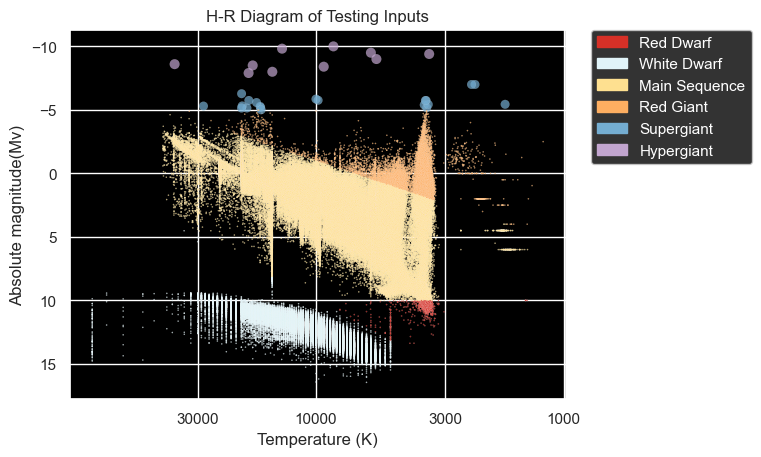

In [52]:
graph(testing_truth,'H-R Diagram of Testing Inputs')

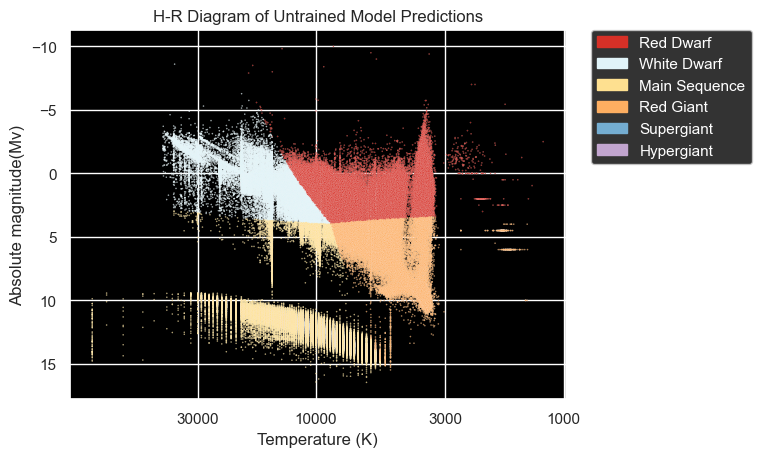

In [84]:
pred = star_nn.predict(testing_intputs_norm)
pred_arr = np.argmax(pred, axis=1) 
graph(pred_arr, 'H-R Diagram of Untrained Model Predictions')

### Training the  Network

In [115]:
star_nn.train(inputs = inputs,truth= truth, val_inputs = val_inputs, val_truth = val_truth, epochs = 300, batch_size = 16)

Starting training:
Epoch: 1, Loss: 1.0148
Epoch: 2, Loss: 0.4149
Epoch: 3, Loss: 0.3022
Epoch: 4, Loss: 0.2286
Epoch: 5, Loss: 0.1774
Epoch: 6, Loss: 0.1387
Epoch: 7, Loss: 0.1178
Epoch: 8, Loss: 0.1075
Epoch: 9, Loss: 0.0971
Epoch: 10, Loss: 0.0971
Epoch: 11, Loss: 0.0853
Epoch: 12, Loss: 0.0805
Epoch: 13, Loss: 0.0794
Epoch: 14, Loss: 0.0735
Epoch: 15, Loss: 0.0731
Epoch: 16, Loss: 0.0664
Epoch: 17, Loss: 0.0641
Epoch: 18, Loss: 0.0611
Epoch: 19, Loss: 0.0602
Epoch: 20, Loss: 0.0562
Epoch: 21, Loss: 0.0503
Epoch: 22, Loss: 0.0512
Epoch: 23, Loss: 0.0480
Epoch: 24, Loss: 0.0470
Epoch: 25, Loss: 0.0460
Epoch: 26, Loss: 0.0441
Epoch: 27, Loss: 0.0485
Epoch: 28, Loss: 0.0401
Epoch: 29, Loss: 0.0406
Epoch: 30, Loss: 0.0392
Epoch: 31, Loss: 0.0418
Epoch: 32, Loss: 0.0386
Epoch: 33, Loss: 0.0394
Epoch: 34, Loss: 0.0400
Epoch: 35, Loss: 0.0340
Epoch: 36, Loss: 0.0337
Epoch: 37, Loss: 0.0353
Epoch: 38, Loss: 0.0332
Epoch: 39, Loss: 0.0319
Epoch: 40, Loss: 0.0405
Epoch: 41, Loss: 0.0302
Epoch:

<br>

### The Neural Network's Final Prediction

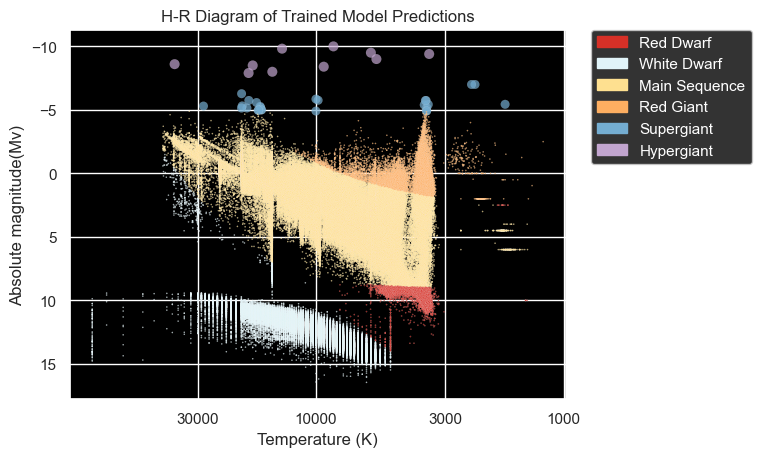

In [116]:
pred = star_nn.predict(testing_intputs_norm)
pred_arr = np.argmax(pred, axis=1) 
graph(pred_arr,'H-R Diagram of Trained Model Predictions')

<br>

### Loss and Loss Validation Charts

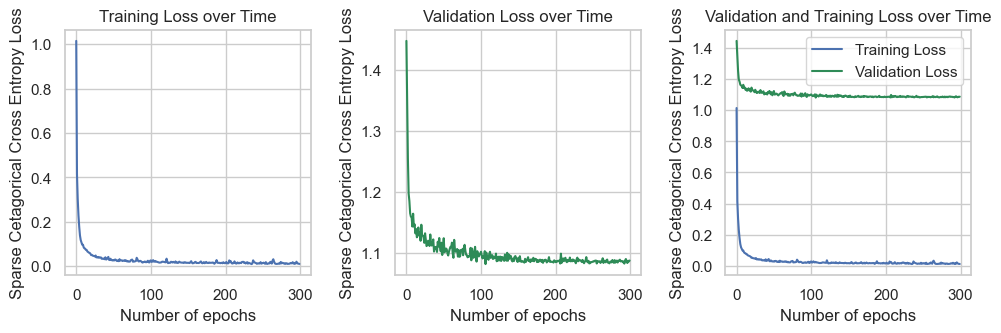

In [117]:
sns.set_style("whitegrid")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.set_size_inches(10, 5)

ax1.set_box_aspect(1)
ax1.plot(np.arange(star_nn.num_epochs), star_nn.metrics['train_loss'])
ax1.set_title('Training Loss over Time')
ax1.set_ylabel('Sparse Cetagorical Cross Entropy Loss')
ax1.set_xlabel('Number of epochs')

ax2.set_box_aspect(1)
ax2.plot(np.arange(star_nn.num_epochs), star_nn.metrics['val_pred_loss'], color = 'seagreen')
ax2.set_title('Validation Loss over Time')
ax2.set_ylabel('Sparse Cetagorical Cross Entropy Loss')
ax2.set_xlabel('Number of epochs')


ax3.set_box_aspect(1)
ax3.plot(np.arange(star_nn.num_epochs), star_nn.metrics['train_loss'],label ="Training Loss")
ax3.plot(np.arange(star_nn.num_epochs), star_nn.metrics['val_pred_loss'],label = "Validation Loss", color = 'seagreen')
ax3.set_title('Validation and Training Loss over Time')
ax3.set_ylabel('Sparse Cetagorical Cross Entropy Loss')
ax3.set_xlabel('Number of epochs')
ax3.legend()


plt.tight_layout() 
plt.show()

<br>

### Training and Validation Accuracy Charts and Category Accuracy

C:\Users\miaed\AppData\Local\Temp\ipykernel_4896\1487038311.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


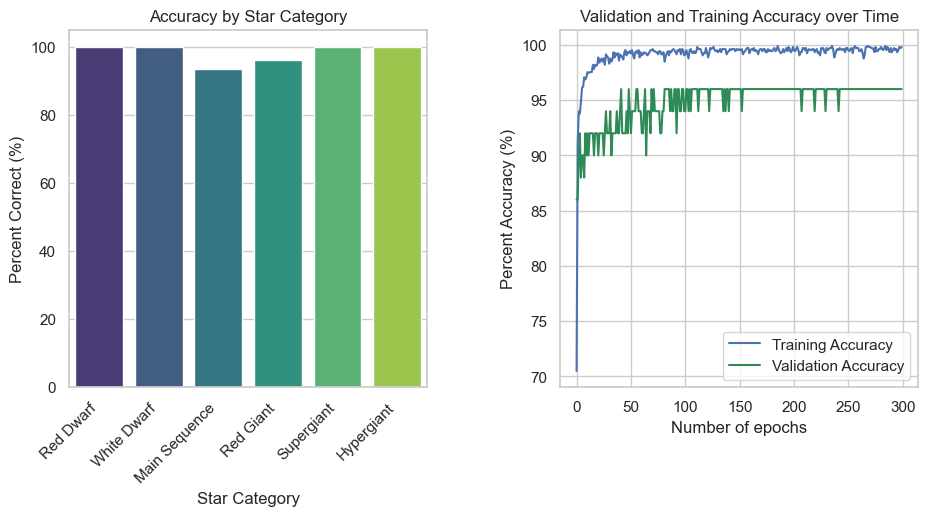

In [118]:
sns.set_style("whitegrid")

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10, 5))
fig.set_size_inches(10, 5)

pred = star_nn.predict(testing_intputs_norm)
pred_arr = np.argmax(pred, axis=1) 

accuracy_per_star = []

for num in sorted(label_map.keys()):
    indx = np.where(testing_truth == num)[0]
    if len(indx) > 0:
        num_correct = np.sum(testing_truth[indx] == pred_arr[indx])
        total_in_category = len(indx)
        
        percent_correct = (num_correct / total_in_category) * 100
        accuracy_per_star.append({
            'Category': label_map[num],
            'Percent Correct': percent_correct
        })
    else:
        accuracy_per_star.append({
            'Category': label_map[num],
            'Percent Correct': 0
        })

accuracy_per_starType_df = pd.DataFrame(accuracy_per_star)
sns.barplot(x='Category', y='Percent Correct', data=accuracy_per_starType_df, palette='viridis', hue='Category', legend=False, ax=ax1)
ax1.set_box_aspect(1)

ax1.set_xlabel('Star Category')
ax1.set_ylabel('Percent Correct (%)')
ax1.set_title('Accuracy by Star Category')
ax1.get_xticklabels()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


ax3.set_box_aspect(1)
ax3.plot(np.arange(star_nn.num_epochs), [i*100 for i in star_nn.metrics['train_accuracy']],label ="Training Accuracy")
ax3.plot(np.arange(star_nn.num_epochs), [i*100 for i in star_nn.metrics['val_pred_accuracy']],label = "Validation Accuracy", color = 'seagreen')
ax3.set_title('Validation and Training Accuracy over Time')
ax3.set_ylabel('Percent Accuracy (%)')
ax3.set_xlabel('Number of epochs')
ax3.legend()

plt.tight_layout() 
plt.show()

<br>

### Confusion and Prediction Pobablilities

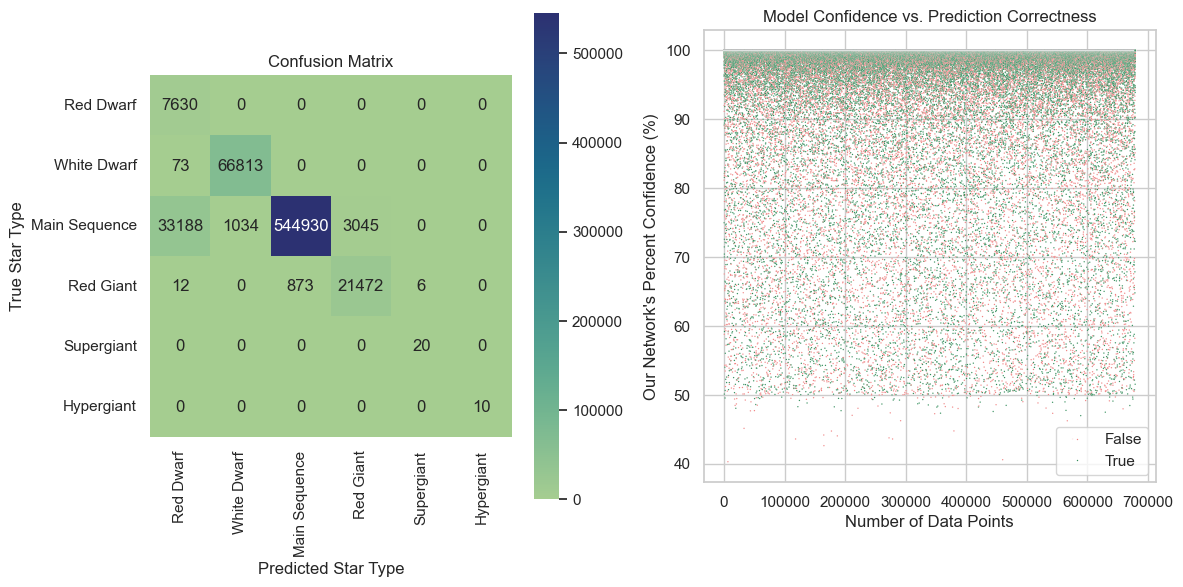

In [119]:
pred = star_nn.predict(testing_intputs_norm)
pred_arr = np.argmax(pred, axis=1) 

cm = confusion_matrix(testing_truth, pred_arr)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_box_aspect(1)
sns.heatmap(cm,annot=True, fmt='d',cmap='crest',       
            xticklabels=['Red Dwarf', 'White Dwarf', 'Main Sequence','Red Giant', 'Supergiant', 'Hypergiant'], 
            yticklabels=['Red Dwarf', 'White Dwarf', 'Main Sequence','Red Giant', 'Supergiant', 'Hypergiant'], ax =ax1)
ax1.set_xlabel('Predicted Star Type')
ax1.set_ylabel('True Star Type')
ax1.set_title('Confusion Matrix')

ax2.set_box_aspect(1)

pred = star_nn.predict(testing_intputs_norm_shuffled)
pred_arr = np.argmax(pred, axis=1) 

confidence = np.max(pred, axis=1)
is_right = (pred_arr == testing_truth_shuffled)
sns.scatterplot( x=np.arange(len(pred_arr)),y=confidence*100,hue=is_right,palette=['lightcoral', 'seagreen'],s=1, ax = ax2)
plt.xlabel('Number of Data Points')
plt.ylabel('Our Network\'s Percent Confidence (%)' )
plt.title('Model Confidence vs. Prediction Correctness')
plt.legend(loc='lower right')
plt.tight_layout() 
plt.show()



<br>

### H-R Diagram Training Progression Over Time

Starting training:
Epoch: 1, Loss: 15.5923
Training completed!


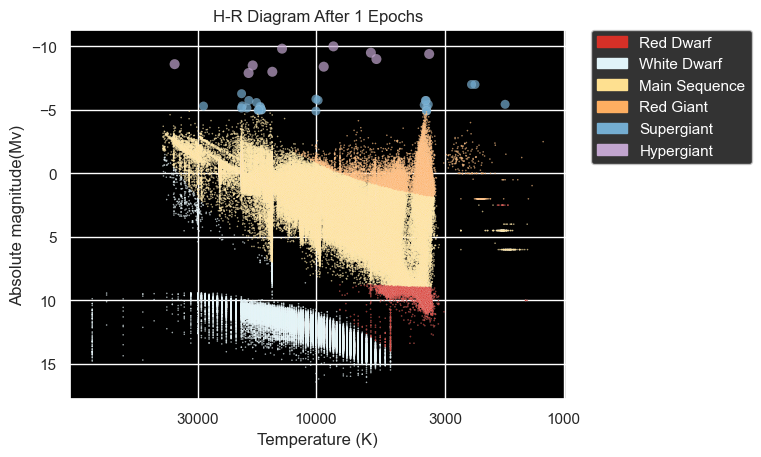

Starting training:
Epoch: 2, Loss: 9.8164
Epoch: 3, Loss: 6.2389
Epoch: 4, Loss: 3.0903
Epoch: 5, Loss: 1.1614
Epoch: 6, Loss: 0.8032
Training completed!


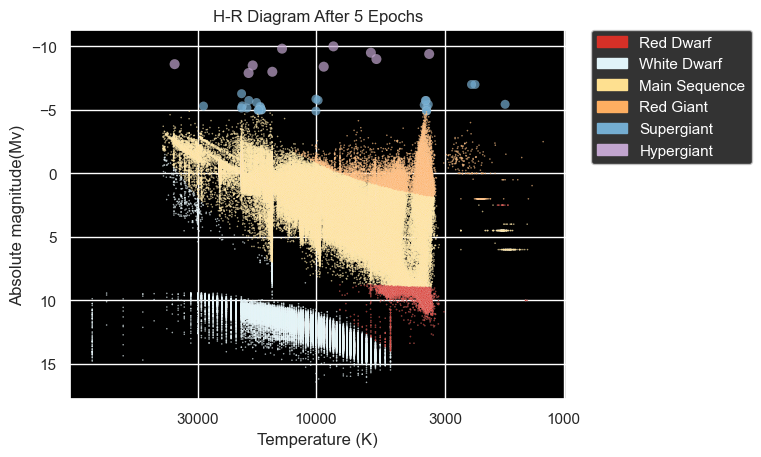

Starting training:
Epoch: 7, Loss: 0.6109
Epoch: 8, Loss: 0.4646
Epoch: 9, Loss: 0.3914
Epoch: 10, Loss: 0.3437
Epoch: 11, Loss: 0.3054
Epoch: 12, Loss: 0.2884
Epoch: 13, Loss: 0.2570
Epoch: 14, Loss: 0.2312
Epoch: 15, Loss: 0.2207
Epoch: 16, Loss: 0.1996
Training completed!


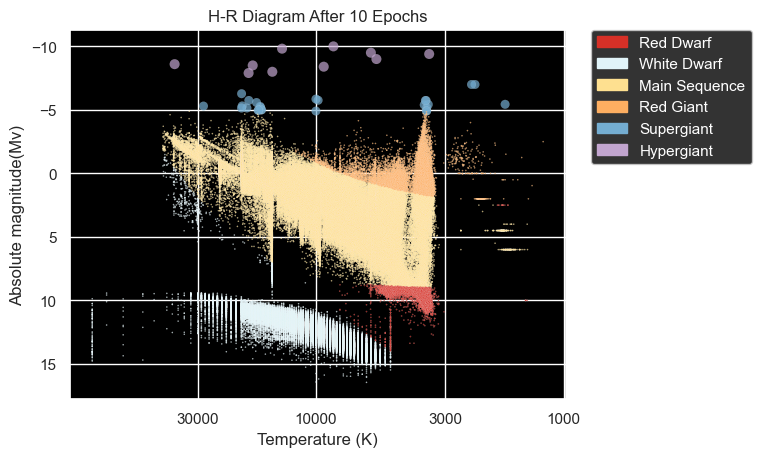

Starting training:
Epoch: 17, Loss: 0.1854
Epoch: 18, Loss: 0.1767
Epoch: 19, Loss: 0.1667
Epoch: 20, Loss: 0.1611
Epoch: 21, Loss: 0.1509
Epoch: 22, Loss: 0.1458
Epoch: 23, Loss: 0.1383
Epoch: 24, Loss: 0.1342
Epoch: 25, Loss: 0.1267
Epoch: 26, Loss: 0.1238
Epoch: 27, Loss: 0.1221
Epoch: 28, Loss: 0.1167
Epoch: 29, Loss: 0.1093
Epoch: 30, Loss: 0.1075
Epoch: 31, Loss: 0.1010
Epoch: 32, Loss: 0.1025
Epoch: 33, Loss: 0.0997
Epoch: 34, Loss: 0.0980
Epoch: 35, Loss: 0.0912
Epoch: 36, Loss: 0.0894
Epoch: 37, Loss: 0.0924
Epoch: 38, Loss: 0.0844
Epoch: 39, Loss: 0.0833
Epoch: 40, Loss: 0.0829
Epoch: 41, Loss: 0.0827
Training completed!


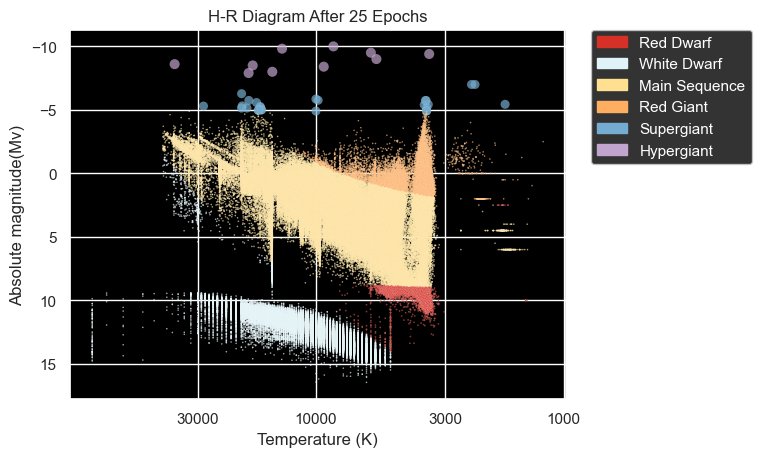

Starting training:
Epoch: 42, Loss: 0.0769
Epoch: 43, Loss: 0.0755
Epoch: 44, Loss: 0.0750
Epoch: 45, Loss: 0.0742
Epoch: 46, Loss: 0.0702
Epoch: 47, Loss: 0.0738
Epoch: 48, Loss: 0.0686
Epoch: 49, Loss: 0.0673
Epoch: 50, Loss: 0.0655
Epoch: 51, Loss: 0.0677
Epoch: 52, Loss: 0.0608
Epoch: 53, Loss: 0.0661
Epoch: 54, Loss: 0.0625
Epoch: 55, Loss: 0.0594
Epoch: 56, Loss: 0.0633
Epoch: 57, Loss: 0.0584
Epoch: 58, Loss: 0.0580
Epoch: 59, Loss: 0.0580
Epoch: 60, Loss: 0.0571
Epoch: 61, Loss: 0.0562
Epoch: 62, Loss: 0.0547
Epoch: 63, Loss: 0.0532
Epoch: 64, Loss: 0.0524
Epoch: 65, Loss: 0.0527
Epoch: 66, Loss: 0.0554
Epoch: 67, Loss: 0.0496
Epoch: 68, Loss: 0.0469
Epoch: 69, Loss: 0.0526
Epoch: 70, Loss: 0.0501
Epoch: 71, Loss: 0.0497
Epoch: 72, Loss: 0.0455
Epoch: 73, Loss: 0.0461
Epoch: 74, Loss: 0.0433
Epoch: 75, Loss: 0.0459
Epoch: 76, Loss: 0.0446
Epoch: 77, Loss: 0.0434
Epoch: 78, Loss: 0.0451
Epoch: 79, Loss: 0.0437
Epoch: 80, Loss: 0.0518
Epoch: 81, Loss: 0.0416
Epoch: 82, Loss: 0.04

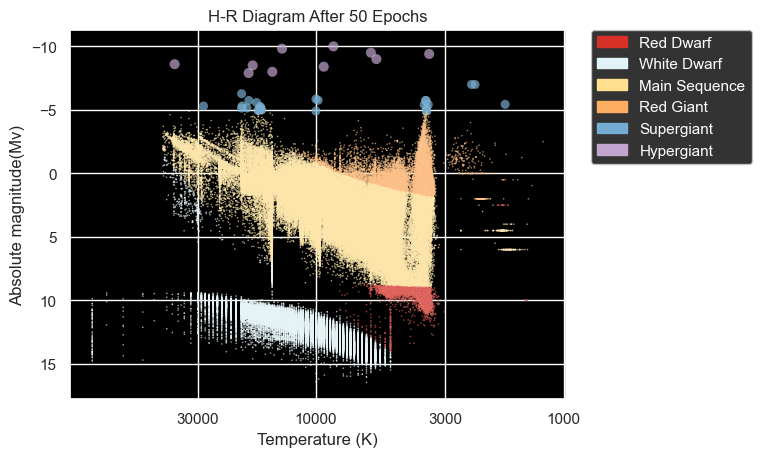

Starting training:
Epoch: 92, Loss: 0.0379
Epoch: 93, Loss: 0.0384
Epoch: 94, Loss: 0.0379
Epoch: 95, Loss: 0.0344
Epoch: 96, Loss: 0.0397
Epoch: 97, Loss: 0.0358
Epoch: 98, Loss: 0.0332
Epoch: 99, Loss: 0.0363
Epoch: 100, Loss: 0.0343
Epoch: 101, Loss: 0.0325
Epoch: 102, Loss: 0.0348
Epoch: 103, Loss: 0.0334
Epoch: 104, Loss: 0.0309
Epoch: 105, Loss: 0.0336
Epoch: 106, Loss: 0.0385
Epoch: 107, Loss: 0.0289
Epoch: 108, Loss: 0.0334
Epoch: 109, Loss: 0.0361
Epoch: 110, Loss: 0.0318
Epoch: 111, Loss: 0.0303
Epoch: 112, Loss: 0.0307
Epoch: 113, Loss: 0.0283
Epoch: 114, Loss: 0.0284
Epoch: 115, Loss: 0.0318
Epoch: 116, Loss: 0.0315
Epoch: 117, Loss: 0.0315
Epoch: 118, Loss: 0.0273
Epoch: 119, Loss: 0.0289
Epoch: 120, Loss: 0.0291
Epoch: 121, Loss: 0.0306
Epoch: 122, Loss: 0.0331
Epoch: 123, Loss: 0.0307
Epoch: 124, Loss: 0.0262
Epoch: 125, Loss: 0.0272
Epoch: 126, Loss: 0.0276
Epoch: 127, Loss: 0.0308
Epoch: 128, Loss: 0.0276
Epoch: 129, Loss: 0.0248
Epoch: 130, Loss: 0.0310
Epoch: 131, Lo

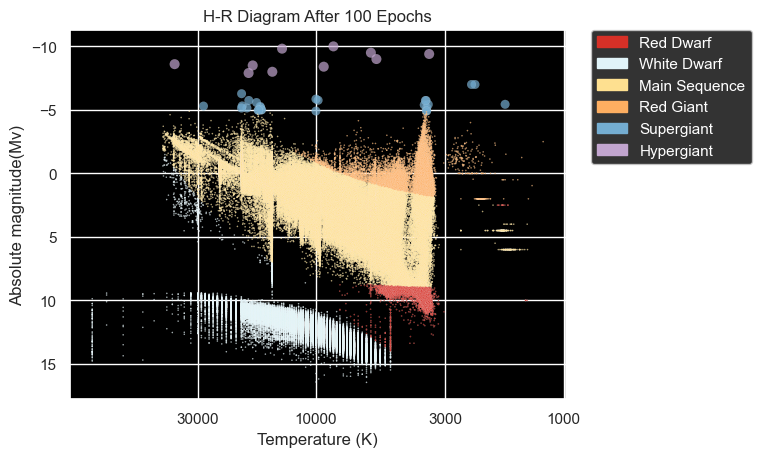

Starting training:
Epoch: 192, Loss: 0.0181
Epoch: 193, Loss: 0.0217
Epoch: 194, Loss: 0.0179
Epoch: 195, Loss: 0.0161
Epoch: 196, Loss: 0.0175
Epoch: 197, Loss: 0.0160
Epoch: 198, Loss: 0.0166
Epoch: 199, Loss: 0.0207
Epoch: 200, Loss: 0.0184
Epoch: 201, Loss: 0.0178
Epoch: 202, Loss: 0.0169
Epoch: 203, Loss: 0.0192
Epoch: 204, Loss: 0.0172
Epoch: 205, Loss: 0.0147
Epoch: 206, Loss: 0.0195
Epoch: 207, Loss: 0.0195
Epoch: 208, Loss: 0.0169
Epoch: 209, Loss: 0.0180
Epoch: 210, Loss: 0.0181
Epoch: 211, Loss: 0.0162
Epoch: 212, Loss: 0.0178
Epoch: 213, Loss: 0.0235
Epoch: 214, Loss: 0.0172
Epoch: 215, Loss: 0.0188
Epoch: 216, Loss: 0.0153
Epoch: 217, Loss: 0.0162
Epoch: 218, Loss: 0.0156
Epoch: 219, Loss: 0.0207
Epoch: 220, Loss: 0.0146
Epoch: 221, Loss: 0.0157
Epoch: 222, Loss: 0.0164
Epoch: 223, Loss: 0.0137
Epoch: 224, Loss: 0.0129
Epoch: 225, Loss: 0.0164
Epoch: 226, Loss: 0.0148
Epoch: 227, Loss: 0.0125
Epoch: 228, Loss: 0.0137
Epoch: 229, Loss: 0.0145
Epoch: 230, Loss: 0.0136
Epoch:

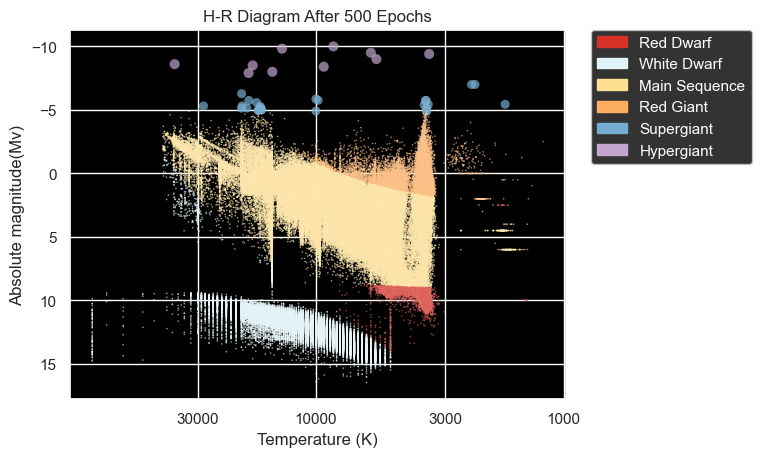

Starting training:
Epoch: 692, Loss: 0.0048
Epoch: 693, Loss: 0.0041
Epoch: 694, Loss: 0.0039
Epoch: 695, Loss: 0.0035
Epoch: 696, Loss: 0.0087
Epoch: 697, Loss: 0.0099
Epoch: 698, Loss: 0.0054
Epoch: 699, Loss: 0.0065
Epoch: 700, Loss: 0.0067
Epoch: 701, Loss: 0.0040
Epoch: 702, Loss: 0.0039
Epoch: 703, Loss: 0.0131
Epoch: 704, Loss: 0.0075
Epoch: 705, Loss: 0.0112
Epoch: 706, Loss: 0.0089
Epoch: 707, Loss: 0.0078
Epoch: 708, Loss: 0.0072
Epoch: 709, Loss: 0.0046
Epoch: 710, Loss: 0.0051
Epoch: 711, Loss: 0.0047
Epoch: 712, Loss: 0.0078
Epoch: 713, Loss: 0.0077
Epoch: 714, Loss: 0.0065
Epoch: 715, Loss: 0.0051
Epoch: 716, Loss: 0.0063
Epoch: 717, Loss: 0.0062
Epoch: 718, Loss: 0.0044
Epoch: 719, Loss: 0.0031
Epoch: 720, Loss: 0.0048
Epoch: 721, Loss: 0.0050
Epoch: 722, Loss: 0.0095
Epoch: 723, Loss: 0.0054
Epoch: 724, Loss: 0.0054
Epoch: 725, Loss: 0.0052
Epoch: 726, Loss: 0.0052
Epoch: 727, Loss: 0.0040
Epoch: 728, Loss: 0.0045
Epoch: 729, Loss: 0.0060
Epoch: 730, Loss: 0.0061
Epoch:

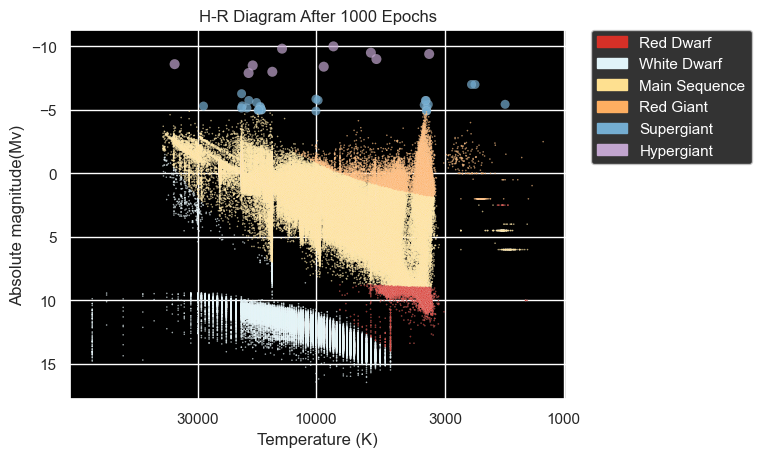

In [120]:
epochs = [1,5, 10, 25, 50, 100, 500, 1000]
star_nn_v2 = Model()

star_nn_v2.addLayer(Linear(input_size = 2, output_size =32))
star_nn_v2.addLayer(ActivationFunc("relu"))

star_nn_v2.addLayer(Linear(input_size = 32, output_size = 16))
star_nn_v2.addLayer(ActivationFunc("relu"))

star_nn_v2.addLayer(Linear(input_size = 16, output_size = 6))

star_nn_v2.compile(learning_rate = 1e-3) 
for e in epochs:
    pred = star_nn.predict(testing_intputs_norm)
    pred_arr = np.argmax(pred, axis=1)
    star_nn_v2.train(inputs = inputs,truth= truth, val_inputs = val_inputs, val_truth = val_truth, epochs = e, batch_size = 16)
    graph(pred_arr, f'H-R Diagram After {e} Epochs')


<br>